In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = "/content/Road Signs classification dataset-20250322T134616Z-001 (1).zip"

extract_path = "/content/DATASET"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)
print('Extraction complete!')

Extraction complete!


In [3]:
import zipfile
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
import os

# Define paths
data_dir = "/content/DATASET/Road Signs classification dataset/DATA"
test_dir = "/content/DATASET/Road Signs classification dataset/TEST"
labels_file = "/content/DATASET/Road Signs classification dataset/labels.csv"

# Load labels
labels_df = pd.read_csv(labels_file)
print(labels_df.head())

# Load and preprocess images
IMG_SIZE = (64, 64)

def load_images(directory):
    images = []
    labels = []
    for class_id in os.listdir(directory):
        class_dir = os.path.join(directory, class_id)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(int(class_id))
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

X_train, y_train = load_images(data_dir)
X_test, y_test = load_images(test_dir)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=30)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=30)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

   ClassId                  Name
0        0   Speed limit (5km/h)
1        1  Speed limit (15km/h)
2        2  Speed limit (30km/h)
3        3  Speed limit (40km/h)
4        4  Speed limit (50km/h)
Training data shape: (743, 64, 64, 3)
Test data shape: (285, 64, 64, 3)


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # Freeze base layers

# Build model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,980,830 (57.15 MB)

 Trainable params: 266,142 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Split training data into train and validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train with data augmentation
history = model.fit(datagen.flow(X_train_split, y_train_split, batch_size=32),
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.0465 - loss: 3.8377 - val_accuracy: 0.0446 - val_loss: 3.4291
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.0538 - loss: 3.5265 - val_accuracy: 0.0893 - val_loss: 3.3146
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.0713 - loss: 3.4196 - val_accuracy: 0.1339 - val_loss: 3.2288
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.1080 - loss: 3.1990 - val_accuracy: 0.2054 - val_loss: 3.1610
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.1073 - loss: 3.1916 - val_accuracy: 0.2232 - val_loss: 3.0895
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.1639 - loss: 3.1014 - val_accuracy: 0.2768 - val_loss: 3.0069
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2047 - loss: 3.0251 - val_accuracy: 0.2946 - val_loss: 2.9476
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2144 - loss: 2.9270 - val_accuracy: 0.3036 - val_loss: 2.8754
Epo

In [6]:
model.save("best_road_sign_classifier.keras")

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Load class names from labels_df
class_names = labels_df['Name'].tolist()
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))


9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4124 - loss: 2.5105
Test Accuracy: 0.4667
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
                          precision    recall  f1-score   support

     Speed limit (5km/h)       0.07      0.25      0.11         4
    Speed limit (15km/h)       0.11      0.50      0.18         6
    Speed limit (30km/h)       0.53      0.90      0.67        10
    Speed limit (40km/h)       0.25      0.25      0.25         4
    Speed limit (50km/h)       1.00      0.08      0.15        12
    Speed limit (60km/h)       0.00      0.00      0.00        21
    Speed limit (70km/h)       0.50      0.13      0.21        15
    speed limit (80km/h)       0.00      0.00      0.00         3
Dont Go straight or left       0.20      0.33      0.25         6
                Unknown7       1.00      0.88      0.93         8
        Dont Go straight       0.40      1.00      0.57        12
            Dont Go Left       0.91      0.45      0.61        22
   Dont Go 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


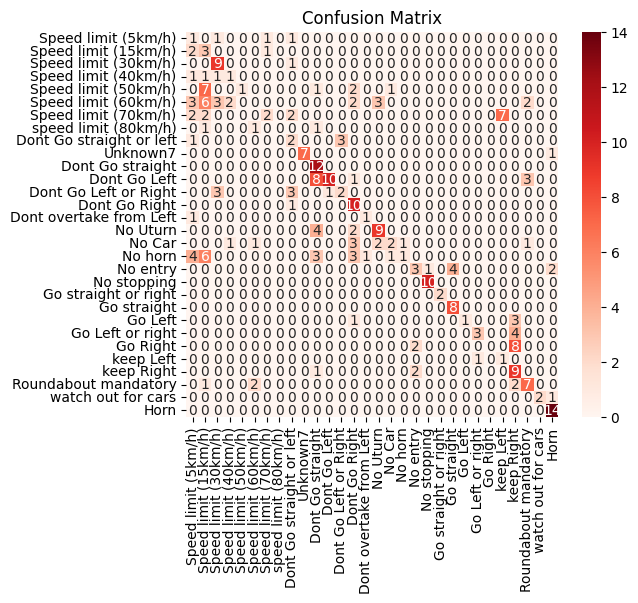

In [9]:
# Confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.show()

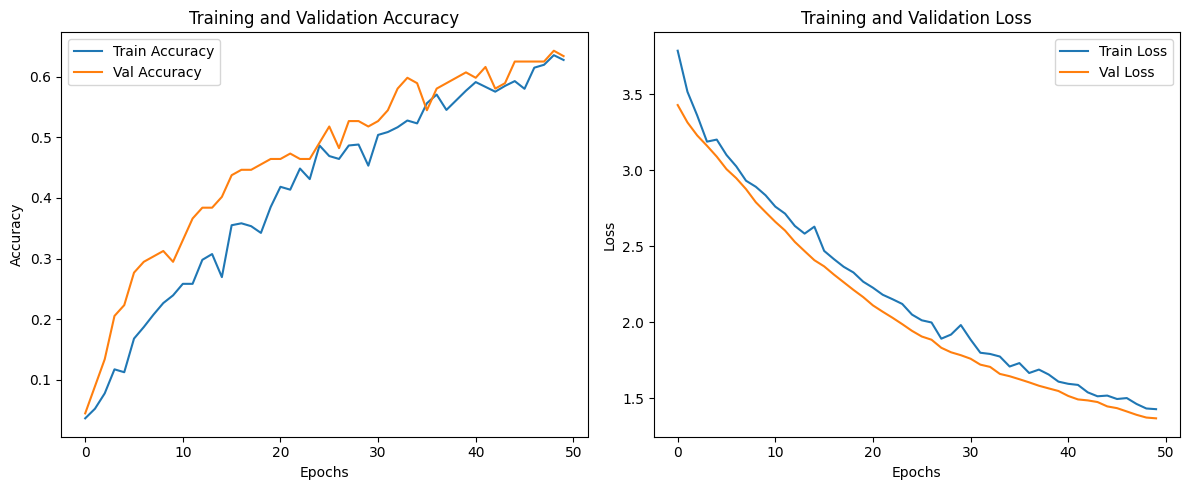

In [10]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


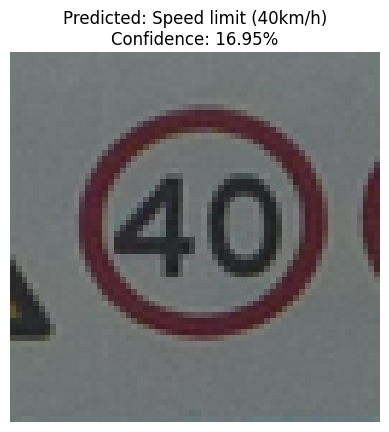

Predicted Class: Speed limit (40km/h)
Confidence: 16.95%


In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the trained model (if not already in memory)
model = tf.keras.models.load_model('/content/best_road_sign_classifier.keras')

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(64, 64)):
    img = Image.open(img_path).convert('RGB').resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize to 0-1
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

test_image_path = "/content/DATASET/Road Signs classification dataset/TEST/3/003_1_0113.png"  # Adjust path

# Load and preprocess the image
img, img_array = load_and_preprocess_image(test_image_path)

# Make prediction
prediction = model.predict(img_array)
predicted_class_idx = np.argmax(prediction)
confidence = np.max(prediction) * 100
class_names = labels_df['Name'].tolist()
predicted_class_name = class_names[predicted_class_idx]

# Display the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class_name}\nConfidence: {confidence:.2f}%")
plt.show()

print(f"Predicted Class: {predicted_class_name}")
print(f"Confidence: {confidence:.2f}%")

In [14]:
%%writefile app.py
import streamlit as st
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import pandas as pd

# Load class names (assumes labels.csv is in the same directory when run locally)
labels_df = pd.read_csv('labels.csv')
class_names = labels_df['Name'].tolist()

st.title("Road Sign Classifier")
model = load_model('best_road_sign_classifier.keras')  # Updated to match saved filename
uploaded_file = st.file_uploader("Upload a road sign image", type=["jpg", "png"])

if uploaded_file:
    img = Image.open(uploaded_file).convert('RGB').resize((64, 64))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    confidence = np.max(pred) * 100
    st.write(f"Predicted Class: {class_names[class_idx]}")
    st.write(f"Confidence: {confidence:.2f}%")
    st.image(img, caption="Uploaded Image")

Writing app.py


In [15]:
pip install ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.3 MB/s eta 0:00:00


In [16]:
pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00


In [17]:
!ngrok config add-authtoken 2vBNxosVC5U5SX8FMNEpLt85D4R_7tiYXhye7Y4qTQ9uVmoL2

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [18]:
import subprocess
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8080"])

<Popen: returncode: None args: ['streamlit', 'run', 'app.py', '--server.port...>

In [19]:
from pyngrok import ngrok
public_url = ngrok.connect(8080)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://1bb2-34-173-170-219.ngrok-free.app" -> "http://localhost:8080"
